# Croissance économique et Santé
--- 
##### Par Thibaut LAUNAY, Jeanne LEMASSON et Christophe REY

# Introduction
---
Ce projet s’inscrit dans le prolongement d’un débat ancien et toujours très actif en macroéconomie et en économie du développement, concernant les liens entre la croissance économique et l’état de santé des populations. La croissance du PIB est souvent présentée comme un levier essentiel d’amélioration du bien-être, notamment par l’augmentation des revenus, l’élargissement de l’assiette fiscale et le financement accru des systèmes de santé. De nombreux travaux empiriques mettent ainsi en évidence une corrélation positive entre le niveau de revenu par habitant et divers indicateurs de santé, tels que l’espérance de vie ou la mortalité infantile.

Cependant, cette relation est loin d’être univoque. D’une part, les limites du PIB comme indicateur synthétique du bien-être sont désormais largement reconnues, et une croissance soutenue ne garantit pas nécessairement une amélioration de la santé si ses fruits sont inégalement répartis ou s’accompagnent de dégradations environnementales. D’autre part, la causalité entre croissance et santé est potentiellement bidirectionnelle : une population en meilleure santé est aussi plus productive, ce qui peut favoriser la croissance économique. Cette endogénéité complique l’identification empirique de l’effet propre de la croissance sur la santé.

On peut ainsi envisager une relation complexe, voire non linéaire, entre croissance économique et santé. Dans les pays à faible niveau de revenu, une accélération de la croissance peut permettre des investissements cruciaux dans les infrastructures sanitaires, l’accès à l’eau potable ou la nutrition, entraînant des gains rapides en matière de santé publique. En revanche, au-delà d’un certain seuil de développement, les gains marginaux de la croissance sur la santé pourraient s’atténuer, tandis que certains effets négatifs comme le stress, la pollution, ou le changement des modes de vie, pourraient limiter, voire inverser ces bénéfices.

Par ailleurs, si les effets de la croissance économique sur la santé physique ont été relativement bien documentés, la question de la santé mentale demeure plus controversée et moins systématiquement intégrée aux analyses macroéconomiques. Or, les troubles mentaux constituent aujourd’hui un enjeu majeur de santé publique à l’échelle mondiale, tant en termes de prévalence que de coûts économiques et sociaux. Stress lié au travail, urbanisation rapide, intensification des rythmes de vie, isolement social ou encore pression à la performance sont autant de facteurs susceptibles de s’accentuer avec le développement économique et de peser négativement sur le bien-être psychologique des individus. Ainsi, une hausse du PIB par habitant pourrait coexister avec une stagnation, voire une dégradation, de l’état de santé mentale des populations.

Ces mécanismes ont été étudiés de manière relativement fragmentée dans la littérature économique, avec des résultats parfois contradictoires selon les indicateurs retenus, les périodes considérées et les méthodes économétriques employées. L’objectif de ce projet est donc d’examiner empiriquement la relation entre croissance économique et santé à partir de données internationales, en distinguant explicitement les dimensions de santé physique et de santé mentale, afin d’identifier l’existence éventuelle de non-linéarités et de mieux comprendre les conditions sous lesquelles la croissance se traduit, ou non, par une amélioration durable et globale de l’état de santé des populations.

NB1 : par souci de lisibilité, certaines fonctions ont été rassemblées dans des scripts et n’apparaissent pas directement dans ce notebook.

### Problématique

Le développement économique d’un pays s’accompagne-t-il nécessairement d’une amélioration de l’état de santé de sa population, ou ses effets diffèrent-ils selon les dimensions de la santé, notamment entre santé physique et santé mentale ?

## Sommaire

### I. Installation  
- Préparation des données  

---

### II. Données de santé   
- Indicateurs de santé  
- Valeurs manquantes  
- Description élémentaire  
- Cartographie  

---

### III. Croissance économique   
- PIB par habitant 
- Valeurs manquantes  
- Description élémentaire  
- Cartographie   

---

### IV. Analyse  
- Fusion des bases de données  
- Régression des indicateurs de santé sur le PIB par habitant   

---

### V. Conclusion et perspectives  


# Installation
---

In [1]:
%pip install pycountry

# Module
import pandas as pd
import requests
import pycountry
import io
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

# Fonctions
from OMS_code_pays import get_headers
from OMS_code_pays import get_facts
from OMS_code_pays import get_iso3
from OMS_code_pays import build_wide_table
from OMS_code_pays import get_data_health_with_iso
import graphiques as gp
from PIB_hab import get_gdp_per_capita_wide
from PIB_hab import get_gdp_per_capita
from desc_indicateur import desc_missing_pib
from desc_indicateur import desc_missing_health
from analyse_pib_habitant import plot_missing_gdp
from analyse_pib_habitant import world_map_gdp

Note: you may need to restart the kernel to use updated packages.


# Données OMS
---
### Indicateurs de santé
Nous avons utilisé les données de l'OMS pour mesurer le lien empirique entre le niveau de PIB par habitant et le niveau de santé car elles donnent accès à de nombreuses informations sur l'état de santé physique de la population des pays du monde. Pour ne pas nous éparpiller sur l'analyse de ces données, nous avons décidé de nous concentrer dans notre étude sur les indicateurs les plus pertinents en termes de santé physique. Ainsi, pour rendre compte de la longévité des populations et de la prise en charge des naissances, nous avons choisi de sélectionner les données relatives à l'espérance de vie et à la mortalité infantile notamment. Ensuite, pour mesurer le niveau de développement du système de santé des pays, nous nous sommes concentrés en particulier sur les données relatives à la densité de personnel médical ou à la part des dépenses de santé dans les dépenses des admnistrations publiques.

Les données sont récupérée via l'API de l'OMS (via un code disponible dans le fichier OMS_code_pays.py).

In [2]:
dfs = get_data_health_with_iso()

df_sdg3 = dfs["SDG3"]
df_sdg_gpw = dfs["SDG_GPW"]

In [3]:
df_sdg3

,LOCATION,Pays_code_iso3,HWF_0010,HWF_0006,HWF_0001,MDG_0000000003_15_19,SDGSUICIDE,FINPROTECTION_CATA_TOT_10_POP,FINPROTECTION_CATA_TOT_25_POP,MDG_0000000003_10_14,...,WHOSIS_000001_BTSX,WHOSIS_000001_FMLE,WHOSIS_000001_MLE,SDGODA01,SDGHPVRECEIVED,SUD_TREATMENTSERVICES_COVERAGE_ALCOHOL,AMR_INFECT_MRSA,AMR_INFECT_ECOLI,SUD_TREATMENTSERVICES_COVERAGE_DRUGS,SDGHEALTHFACILITIESESSENTIALMEDS
0,Afghanistan,AFG,0.06,5.49,3.17,62.0,3.6,26.08,8.03,18.0,...,59.1,61.0,57.4,4.81,NaN,NaN,NaN,NaN,NaN,NaN
1,Albania,ALB,10.27,58.21,18.79,9.8,2.8,8.85,1.41,0.2,...,76.4,78.6,74.4,3.4,74,NaN,NaN,NaN,NaN,NaN
2,Algeria,DZA,3.57,25.08,16.6,11.0,2.2,NaN,NaN,NaN,...,76.0,76.6,75.5,0.04,NaN,NaN,NaN,NaN,NaN,NaN
3,Andorra,AND,12.11,47.22,50.68,0.5,NaN,NaN,NaN,0,...,NaN,NaN,NaN,NaN,85,NaN,NaN,NaN,NaN,NaN
4,Angola,AGO,0.07,18.73,2.44,NaN,8.1,35.53,12.48,NaN,...,62.1,64.3,60.0,1.32,NaN,0.4,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
193,Venezuela (Bolivarian Republic of),None,1.35,20.03,16.64,76.0,8.6,NaN,NaN,2.5,...,71.2,75.9,66.9,2.01,NaN,NaN,NaN,NaN,NaN,NaN
194,Viet Nam,VNM,NaN,14.41,11.07,29.0,7.3,8.46,1.73,NaN,...,73.8,78.0,69.7,0.58,NaN,NaN,NaN,NaN,NaN,NaN
195,Yemen,YEM,0.19,5.41,0.98,77.0,4.2,NaN,NaN,NaN,...,65.8,68.6,63.1,2.89,NaN,NaN,93.5,90.4,NaN,NaN
196,Zambia,ZMB,0.14,29.36,3.24,134.6,7.1,0.28,0.01,2.9,...,61.0,63.1,58.7,7.29,56,NaN,90,76.5,NaN,16.7


In [4]:
df_sdg_gpw

,LOCATION,Pays_code_iso3,NUTOVERWEIGHTPREV,GHED_GGHE_DGGE_SHA2011,NUTRITION_ANAEMIA_REPRODUCTIVEAGE_PREV,SDGPM25,SDGODAWS,WSH_WATER_SAFELY_MANAGED,PHE_HHAIR_PROP_POP_CLEAN_FUELS,SDGIPV12M,VIOLENCE_HOMICIDERATE,NUTRITION_WH_2,NUTSTUNTINGPREV,WSH_HYGIENE_BASIC,SDGIPVLT,WSH_DOMESTIC_WASTE_SAFELY_TREATED,WSH_SANITATION_SAFELY_MANAGED
0,Afghanistan,AFG,4.4,1.13,45.4,75.19,46.1,30,38.6,35,8.3,3.6,42.0,48,46,6.1,NaN
1,Albania,ALB,16.7,9.19,24.7,16.58,43.7,71,86.1,6,3.4,1.6,7.4,NaN,13,12.7,56
2,Algeria,DZA,13.3,5.36,31.6,22.85,0.3,71,99.7,NaN,1.6,2.7,8.9,85,NaN,76.2,62
3,Andorra,AND,NaN,15.87,16.4,8.88,NaN,91,100.0,NaN,NaN,NaN,NaN,NaN,NaN,100.0,100
4,Angola,AGO,4.7,6.7,43.8,32.32,17.4,NaN,50.2,25,8.7,4.9,47.7,NaN,38,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
193,Venezuela (Bolivarian Republic of),None,7.3,6.01,25.2,16.55,2.3,NaN,93.5,8,63.1,NaN,11.7,NaN,19,NaN,27
194,Viet Nam,VNM,10.5,10.7,20.5,22.12,282.0,58,98.7,10,1.9,4.4,19.2,89,25,40.8,44
195,Yemen,YEM,1.7,2.51,36.4,43.04,86.5,NaN,47.3,NaN,9.4,16.8,47.4,NaN,NaN,NaN,19
196,Zambia,ZMB,6.3,8.89,27.1,18.85,53.6,NaN,9.2,28,5.9,4.2,32.3,18,41,NaN,NaN


Ces dataframes ont été sauvegarder en format csv pour compléter les derniers codes pays n'ayant pas été créé par le module pycountry et pour renommer les colonnes étant nommées par des codes non-explicites. Les dossiers modifiés sont les fichiers : WHO_SDG_GPW_standardisé_avec_code_pays_complet.csv et WHO_SDG3_standardisé_avec_code_pays_complet.csv du dossier Données OMS.

In [5]:
df_gpw = pd.read_csv('/home/onyxia/python-DATA/Données_OMS/WHO_SDG_GPW_standardisé_avec_code_pays_complet.csv')
df_gpw

,LOCATION,Pays_code_iso3,Surpoids enfants <5 ans,Dépenses publiques santé,Anémie femmes 15-49 ans,Concentration particules air PM2.5,Aide eau et assainissement,Accès eau potable sûre,Usage combustibles propres,Violences conjugales sur la dernière année,Taux d'homicides,Indicateur nutrition poids/taille,Retard croissance enfants,Accès hygiène de base,Violences conjugales à vie,Déchets domestiques traités,Niveau d'assainissement
0,Afghanistan,AFG,4.4,1.13,45.4,75.19,46.1,30.0,38.6,35.0,8.3,3.6,42.0,48.0,46.0,6.1,NaN
1,Albania,ALB,16.7,9.19,24.7,16.58,43.7,71.0,86.1,6.0,3.4,1.6,7.4,NaN,13.0,12.7,56.0
2,Algeria,DZA,13.3,5.36,31.6,22.85,0.3,71.0,99.7,NaN,1.6,2.7,8.9,85.0,NaN,76.2,62.0
3,Andorra,AND,NaN,15.87,16.4,8.88,NaN,91.0,100.0,NaN,NaN,NaN,NaN,NaN,NaN,100.0,100.0
4,Angola,AGO,4.7,6.70,43.8,32.32,17.4,NaN,50.2,25.0,8.7,4.9,47.7,NaN,38.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
192,Venezuela,VEN,7.3,6.01,25.2,16.55,2.3,NaN,93.5,8.0,63.1,NaN,11.7,NaN,19.0,NaN,27.0
193,Viet Nam,VNM,10.5,10.70,20.5,22.12,282.0,58.0,98.7,10.0,1.9,4.4,19.2,89.0,25.0,40.8,44.0
194,Yemen,YEM,1.7,2.51,36.4,43.04,86.5,NaN,47.3,NaN,9.4,16.8,47.4,NaN,NaN,NaN,19.0
195,Zambia,ZMB,6.3,8.89,27.1,18.85,53.6,NaN,9.2,28.0,5.9,4.2,32.3,18.0,41.0,NaN,NaN


In [6]:
df_sdg3 = pd.read_csv('/home/onyxia/python-DATA/Données_OMS/WHO_SDG3_standardisé_avec_code_pays_complet.csv')
df_sdg3

,LOCATION,Pays_code_iso3,Médecins pour 10k habitants,Personnel infirmier densité,Personnel de santé total,Grossesse adolescentes 15-19,Taux de suicides,Dépenses santé catastrophiques 10%,Dépenses santé catastrophiques 25%,Grossesse adolescentes 10-14,...,Espérance de vie totale,Espérance de vie femmes,Espérance de vie hommes,Aide santé internationale,Vaccination HPV filles,Traitement troubles alcool,Infections résistantes MRSA,Infections résistantes E.coli,Traitement dépendances drogues,Accès médicaments essentiels
0,Afghanistan,AFG,0.06,5.49,3.17,62.0,3.6,26.08,8.03,18.0,...,59.1,61.0,57.4,4.81,NaN,NaN,NaN,NaN,NaN,NaN
1,Albania,ALB,10.27,58.21,18.79,9.8,2.8,8.85,1.41,0.2,...,76.4,78.6,74.4,3.40,74.0,NaN,NaN,NaN,NaN,NaN
2,Algeria,DZA,3.57,25.08,16.60,11.0,2.2,NaN,NaN,NaN,...,76.0,76.6,75.5,0.04,NaN,NaN,NaN,NaN,NaN,NaN
3,Andorra,AND,12.11,47.22,50.68,0.5,NaN,NaN,NaN,0.0,...,NaN,NaN,NaN,NaN,85.0,NaN,NaN,NaN,NaN,NaN
4,Angola,AGO,0.07,18.73,2.44,NaN,8.1,35.53,12.48,NaN,...,62.1,64.3,60.0,1.32,NaN,0.4,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
192,Venezuela,VEN,1.35,20.03,16.64,76.0,8.6,NaN,NaN,2.5,...,71.2,75.9,66.9,2.01,NaN,NaN,NaN,NaN,NaN,NaN
193,Viet Nam,VNM,NaN,14.41,11.07,29.0,7.3,8.46,1.73,NaN,...,73.8,78.0,69.7,0.58,NaN,NaN,NaN,NaN,NaN,NaN
194,Yemen,YEM,0.19,5.41,0.98,77.0,4.2,NaN,NaN,NaN,...,65.8,68.6,63.1,2.89,NaN,NaN,93.5,90.4,NaN,NaN
195,Zambia,ZMB,0.14,29.36,3.24,134.6,7.1,0.28,0.01,2.9,...,61.0,63.1,58.7,7.29,56.0,NaN,90.0,76.5,NaN,16.7


### Valeurs manquantes

In [7]:
desc_missing_health(df_sdg3, 'Espérance de vie totale', 'LOCATION')

The dataframe includes 197 countries and 13 missing values.
The percentage of missing values for Espérance de vie totale in the dataset is 6.60%.


In [8]:
desc_missing_health(df_gpw, 'Dépenses publiques santé', 'LOCATION')

The dataframe includes 197 countries and 5 missing values.
The percentage of missing values for Dépenses publiques santé in the dataset is 2.54%.


# Croissance économique
---
### PIB par habitant
Nous utilisons le PIB par habitant pour rendre compte du niveau de richesse des pays car cet indicateur indique le niveau de revenu individuel moyen de la population et n'est donc pas biaisé par la taille du pays comme c'est le cas avec le PIB. Cela le rend plus pertinent pour classer les pays en termes de revenus.

Les données sont récupérées via l'API de la WorldBank (et sont sauvegardée dans le fichier Données_PIB_habitant_2015_2024.py)

In [9]:

df = get_gdp_per_capita_wide()
df

,Country Name,Country Code,2015,2016,2017,2018,2019,2020,2021,2022,2023,2024
0,Afghanistan,AFG,565.569730,522.082216,525.469771,491.337221,496.602504,510.787063,356.496214,357.261153,413.757895,NaN
1,Africa Eastern and Southern,AFE,1498.875240,1334.470500,1528.104224,1552.073722,1507.085600,1351.591669,1562.416175,1679.327622,1571.449189,1615.396356
2,Africa Western and Central,AFW,1860.727686,1630.039439,1574.230564,1720.140092,2216.385055,2030.861659,2112.794076,2138.473153,1841.855064,1411.337029
3,Albania,ALB,4199.539129,4457.634122,5006.360130,5897.654526,6069.439031,6027.913507,7242.455131,7756.961887,9730.869219,11377.775743
4,Algeria,DZA,4685.059027,4424.985290,4554.667540,4577.210292,4468.453419,3743.541952,4160.559267,4960.303343,5370.477235,5752.990767
...,...,...,...,...,...,...,...,...,...,...,...,...
261,West Bank and Gaza,PSE,3272.154324,3527.613824,3620.360487,3562.330943,3656.858271,3233.568638,3678.635657,3799.955270,3455.028529,2592.305912
262,World,WLD,10161.944577,10204.928776,10747.764307,11309.383077,11376.081813,10937.684621,12390.668672,12798.165847,13236.716396,13631.204310
263,"Yemen, Rep.",YEM,1362.173812,975.359417,811.165970,633.887202,NaN,NaN,NaN,NaN,NaN,NaN
264,Zambia,ZMB,1295.877887,1239.085279,1483.465773,1463.899979,1258.986198,951.644317,1127.160779,1447.123101,1330.727806,1187.109434


### Valeurs manquantes

In [10]:
desc_missing_pib(df, '2024', 'Country Name')

The dataframe includes 266 countries and 26 missing values.
The percentage of missing values for the GDP per capita of 2024 in the dataset is 9.77%.


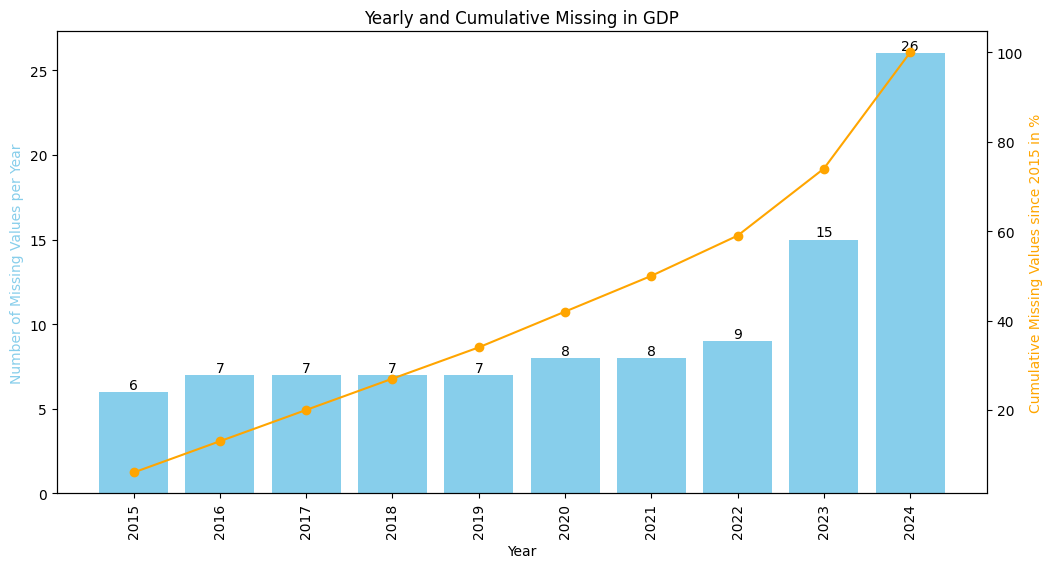

In [11]:
df = get_gdp_per_capita()
plot_missing_gdp(df)

In [12]:
world_map_gdp(df)

### Régression des indicateurs de santé selon le groupe de niveau de richesse

--- Démarrage du programme ---
--> Fichier 'Table_groupes_pays_richesse.csv' chargé avec succès (277 lignes).
--> Nettoyage des données...
--> Calcul de la moyenne de 'Espérance de vie en bonne santé totale' par groupe...

Résultats :
IncomeGroup
Low income             54.320000
Lower middle income    58.424490
Upper middle income    62.384000
High income            67.658621
Name: Espérance de vie en bonne santé totale, dtype: float64
--> Affichage du graphique.


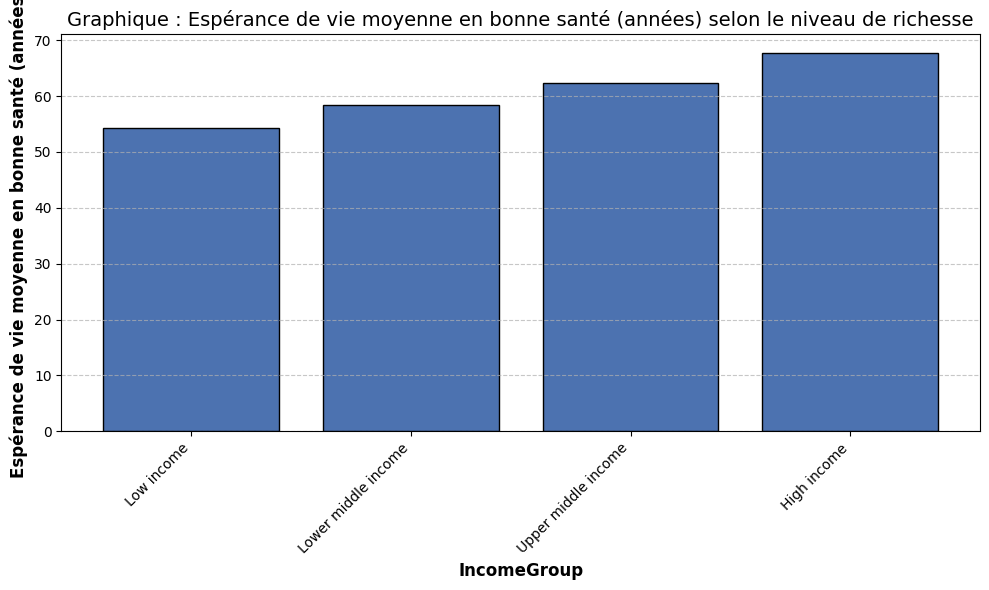

In [13]:
gp.esperancetotale()